In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score

pd.set_option('display.max_columns', 100)

ModuleNotFoundError: No module named 'geopandas'

In [78]:
# Get all of the data
listings = pd.read_csv("listings.csv")
neighbourhoods = gpd.read_file("neighbourhoods.geojson", driver="GeonJSON")
reviews = pd.concat([pd.read_csv("reviews_1.csv"), pd.read_csv("reviews_2.csv")])

In [79]:
# Let's look at the listings dataset. Always start by examining the data itself. 
# In this case, it's the csv, or comma-separated-values file.

In [ ]:
# The `price` column seems very important. Can we use it as it is?
listings["prices_fixed"] = listings["price"].str.replace(",", "").str[1:].astype(float)
listings["prices_fixed"]

listings = listings.fillna(0)

In [ ]:
# This data is geographical! Let's put it on a map.
listings["geometry"] = [Point(long, lat) for long, lat in zip(listings["longitude"], listings["latitude"])]
gpd_listings = gpd.GeoDataFrame(listings)

fix, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax)
gpd_listings.plot(ax=ax, column="price", cmap="plasma", alpha=0.5)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
grouped_listings = listings.groupby("neighbourhood_cleansed").mean(numeric_only=True)['prices_fixed'].reset_index().rename({"neighbourhood_cleansed": "neighbourhood"}, axis=1)
# grouped_listings = listings.groupby("neighbourhood_cleansed").count()['prices_fixed'].reset_index().rename({"neighbourhood_cleansed": "neighbourhood"}, axis=1)
grouped_listings
merged_df = pd.merge(neighbourhoods, grouped_listings, on="neighbourhood")
merged_df.plot(column="prices_fixed", cmap="plasma", legend=True, ax=ax)

In [87]:
# Let's take a deeper look by making some plots

# groupby options: beds, neighbourhood, room_type, neighbourhood_cleansed, property_type, room_type
# y-value options: prices_fixed, min/maximum nights, accommodates

groupby_variable = "beds"
y_value = "prices_fixed"

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
listings.groupby(groupby_variable)[y_value].mean().plot(kind="bar", ax=axs[0], title=f"Average {y_value}")
listings.groupby(groupby_variable)[y_value].count().plot(kind="bar", ax=axs[1], title="Count of Listings")
fig.tight_layout()

In [ ]:
# Let's take a deeper look by making some scatter

# groupby options: beds, neighbourhood, room_type, neighbourhood_cleansed, property_type, room_type
# y-value options: prices_fixed, min/maximum nights, accommodates

x_value = "beds"
y_value = "prices_fixed"

listings.plot(x=x_value, y=y_value, kind="scatter", alpha=0.2)

In [ ]:
# Correlations are often really insightful
listings.select_dtypes(include=np.number).corr().to_csv("listing_correlations.csv")

In [ ]:
# Introduction to Feature Engineering
neighbourhood_dummies = pd.get_dummies(listings["neighbourhood_cleansed"], prefix="NBH_dummy")
listings = pd.concat([listings, neighbourhood_dummies], axis=1)

In [114]:
# Let's build a model!
features = ["beds", "accommodates", "availability_365"]

# neighbourhood_columns = neighbourhood_dummies.columns
# features += list(neighbourhood_columns)

target = "prices_fixed"
model_type = "regression"
# estimators = 100


if model_type == "regression":
    model = RandomForestRegressor()
else:
    model = RandomForestClassifier()

shuffled_data = listings.sample(len(listings))
train_data = shuffled_data[:int(len(shuffled_data)*0.8)]
validation_data = shuffled_data[int(len(shuffled_data)*0.8):]

model.fit(listings[features], listings[target])
# model.fit(train_data[features], train_data[target])

listings[f"predicted_{target}"] = model.predict(listings[features])
# train_data[f"predicted_{target}"] = model.predict(train_data[features])
# validation_data[f"predicted_{target}"] = model.predict(validation_data[features])

# How do we measure our success?
print("mean_absolute_error: ", mean_absolute_error(listings[target], listings[f"predicted_{target}"]))
print("mean_squared_error", mean_squared_error(listings[target], listings[f"predicted_{target}"]))
print("R**2", r2_score(listings[target], listings[f"predicted_{target}"]))


# print("Training Data Statistics")
# print("mean_absolute_error: ", mean_absolute_error(train_data[target], train_data[f"predicted_{target}"]))
# print("mean_squared_error", mean_squared_error(train_data[target], train_data[f"predicted_{target}"]))
# print("R**2", r2_score(train_data[target], train_data[f"predicted_{target}"]))
# print("")

# print("Validation Data Statistics")
# print("mean_absolute_error: ", mean_absolute_error(validation_data[target], validation_data[f"predicted_{target}"]))
# print("mean_squared_error", mean_squared_error(validation_data[target], validation_data[f"predicted_{target}"]))
# print("R**2", r2_score(validation_data[target], validation_data[f"predicted_{target}"]))

print("")
for i in range(len(model.feature_importances_)):
    print(f"{features[i]}: {model.feature_importances_[i]}")

mean_absolute_error:  109.5815736118012
mean_squared_error 114887.8136838673
R**2 0.5666037662741878


C:\Users\mace_\AppData\Local\Temp\ipykernel_10140\736759985.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:,f"predicted_{target}"] = model.predict(train_data[features])
C:\Users\mace_\AppData\Local\Temp\ipykernel_10140\736759985.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data.loc[: ,f"predicted_{target}"] = model.predict(validation_data[features])
C:\Users\mace_\AppData\Local\Temp\ipykernel_10140\736759985.py:13: SettingWithCopyWarning: 
A value is trying to be set

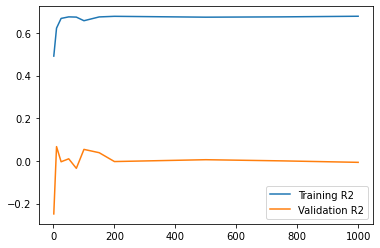

In [118]:
# How do we know how well this will do outside of our dataset?
# Let's look at R**2 as a function of estimators

training_r2s = []
validation_r2s = []

estimator_options = [1, 10, 25, 50, 75, 100, 150, 200, 500, 750, 1000]

for estimators in estimator_options:
    model = RandomForestRegressor(estimators)
    model.fit(train_data[features], train_data[target])

    train_data.loc[:,f"predicted_{target}"] = model.predict(train_data[features])
    validation_data.loc[: ,f"predicted_{target}"] = model.predict(validation_data[features])

    current_train_r2_score = r2_score(train_data[target], train_data[f"predicted_{target}"])
    current_validation_r2_score = r2_score(validation_data[target], validation_data[f"predicted_{target}"])

    # current_train_r2_score = mean_squared_error(train_data[target], train_data[f"predicted_{target}"])
    # current_validation_r2_score = mean_squared_error(validation_data[target], validation_data[f"predicted_{target}"])

    training_r2s.append(current_train_r2_score)
    validation_r2s.append(current_validation_r2_score)

plt.plot(estimator_options, training_r2s)
plt.plot(estimator_options, validation_r2s)
plt.legend(["Training R2", "Validation R2"])
plt.show()

In [ ]:
# Create predicted/actual plots

In [1]:
fig, ax = plt.subplots(figsize=(10, 10))
train_data.plot(x='prices_fixed', y=f"predicted_{target}", ax=ax, kind="scatter")
validation_data.plot(x='prices_fixed', y=f"predicted_{target}", ax=ax, kind="scatter", color="orange")
plt.plot([i for i in range(int(max(train_data["prices_fixed"])))], [i for i in range(int(max(train_data["prices_fixed"])))])

NameError: name 'plt' is not defined